1.1 IMPORTING LIBRARIES:

In [45]:
import warnings 
warnings.filterwarnings('ignore')

# basic libraries
import os
import numpy as np
import pandas as pd
import time

#visulaization modules
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline




#Data Preprocessing Tools
from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   OneHotEncoder,
                                   MinMaxScaler)
from sklearn import metrics
from sklearn.model_selection import train_test_split


#Metrics
from sklearn.metrics import (accuracy_score, 
                             auc, 
                             precision_score,
                             recall_score,
                             f1_score, 
                             roc_auc_score,
                             confusion_matrix)
from sklearn.model_selection import (GridSearchCV,
                                     StratifiedKFold,
                                     cross_val_score)

# Stats
from scipy.stats import kurtosis, skew

# model algorithams
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier,
                              ExtraTreesClassifier)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis)


In [46]:
# set the font globally
plt.rcParams.update({'font.family':'sans-serif'})

In [47]:
# loading data
df = pd.read_csv('/content/drive/MyDrive/Diabet/diabetes.csv', delimiter = ',', encoding = 'utf-8')
print(f'We have {df.shape[0]} instances and the following {df.shape[1]} attributes:')
df.head(5)

We have 768 instances and the following 9 attributes:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


1.2 DESCRIPTIVE STATISTICS

In [48]:
df.describe().T.style.set_table_attributes("style='display:inline'").bar(color='#C0C0C0')

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000000,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,17.000000
Glucose,768.000000,120.894531,31.972618,0.000000,99.000000,117.000000,140.250000,199.000000
BloodPressure,768.000000,69.105469,19.355807,0.000000,62.000000,72.000000,80.000000,122.000000
SkinThickness,768.000000,20.536458,15.952218,0.000000,0.000000,23.000000,32.000000,99.000000
Insulin,768.000000,79.799479,115.244002,0.000000,0.000000,30.500000,127.250000,846.000000
BMI,768.000000,31.992578,7.884160,0.000000,27.300000,32.000000,36.600000,67.100000
DiabetesPedigreeFunction,768.000000,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,2.420000
Age,768.000000,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,81.000000
Outcome,768.000000,0.348958,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000


Visualizing Null Data

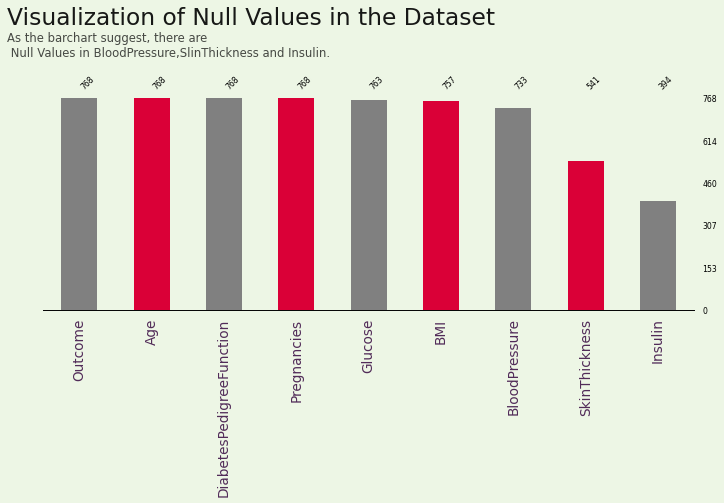

In [49]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
color = ['grey','#DA0037']*4
fig, ax = plt.subplots(figsize = (12,4), dpi = 70)
fig.patch.set_facecolor('#EDF6E5')
ax.set_facecolor('#EDF6E5')


msno.bar(df, sort = 'descending', 
         color = color, 
         ax = ax, fontsize =8,
         labels = 'off',filter = 'top')

ax.text(-1,1.35,'Visualization of Null Values in the Dataset',{'Size': 24,  'color':'black'},alpha = 0.9)
ax.text(-1,1.2,'As the barchart suggest, there are \n Null Values in BloodPressure,SlinThickness and Insulin.',{ 'Size': 12,  'color':'black'}, alpha = 0.7)

ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, 
                   ha = 'center', **{'Size': 14,'weight':'normal','color':'#512b58'}, alpha = 1)
ax.set_yticklabels('')
ax.spines['bottom'].set_visible(True)

fig.show()

Null accuracy Score

In [50]:
null_acc = round (max(df.Outcome.values.mean(), 1 - df.Outcome.values.mean()), 2)

print(f'\nNull Accuracy Score: {null_acc*100}% \n' )

print('This is the Baseline accuracy our model we need to cross.\n')


Null Accuracy Score: 65.0% 

This is the Baseline accuracy our model we need to cross.



2. Data Pre-Processing

Median Imputation

In [51]:
def impute_median(var,data):   
    imputed_data = data[data[var].notnull()]
    imputed_data = imputed_data[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return imputed_data

Feature Engineering for Data Visualization

In [52]:
missing_val_columns = ['BloodPressure','SkinThickness','Insulin','Glucose','BMI']
for col in missing_val_columns:
    med0,med1 = impute_median(col,df)[col]
    df.loc[(df['Outcome'] == 0 ) & (df[col].isnull()), col]=med0
    df.loc[(df['Outcome'] == 1 ) & (df[col].isnull()), col]=med1

3. Exploratory Data Analysis

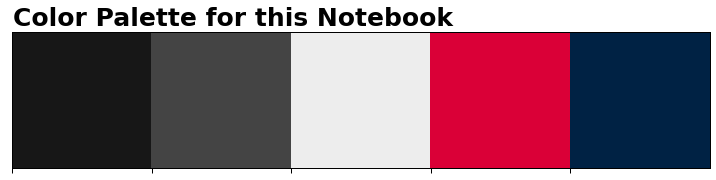

In [53]:
# color palette for visualizations
colors = ['#171717','#444444','#EDEDED','#DA0037','#002244']
palette = sns.color_palette( palette = colors)

sns.palplot(palette, size =2.5)
plt.text(-0.49,-0.55,'Color Palette for this Notebook', {'size':25, 'weight':'bold'})
plt.show()

3.1 Data Imbalance

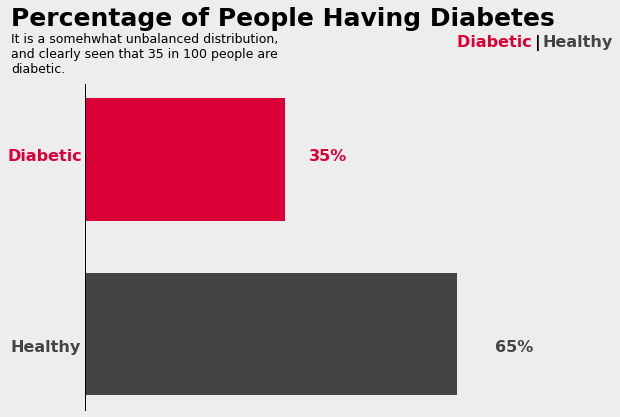

In [54]:
x = pd.DataFrame(df.groupby(['Outcome']).Outcome.count())

fig , ax = plt.subplots(figsize=(7,6))
ax.barh([1], x.Outcome[1], height=0.7, color= colors[3])
ax.barh([0], x.Outcome[0], height=0.7, color= colors[1])

fig.patch.set_facecolor(colors[2])
ax.set_facecolor(colors[2])

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.text(-100,-0.1, 'Healthy',{'weight':'bold','Size': '16','style':'normal', 'color':colors[1]})
plt.text(550,-0.1, '65%',{'weight':'bold' ,'size':'16','color':colors[1]})
plt.text(-105,1, 'Diabetic', {'weight':'bold','Size': '16','style':'normal', 'color':colors[3]})
plt.text(300,1, '35%',{ 'weight':'bold','size':'16','color':colors[3]})

plt.text(-100,1.77, 'Percentage of People Having Diabetes' ,{ 'Size': '25','weight':'bold', 'color':'black'})
plt.text(500,1.65, 'Diabetic ', {'weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':colors[3]})
plt.text(605,1.65, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
plt.text(615,1.65, 'Healthy', {'weight':'bold', 'Size': '16','style':'normal', 'weight':'bold','color':colors[1]})
plt.text(-100,1.5, 'It is a somehwhat unbalanced distribution,\nand clearly seen that 35 in 100 people are\ndiabetic.', 
        { 'size':'12.5','color': 'black'})
plt.show()

In [75]:
df['Outcome']=1
indices1 = np.random.choice(np.arange(df['Outcome'].size), replace=False,
                           size=int(df['Outcome'].size * 0.90))
df['Outcome'][indices1]=0


In [76]:
df.groupby('Outcome').size()[1]

77

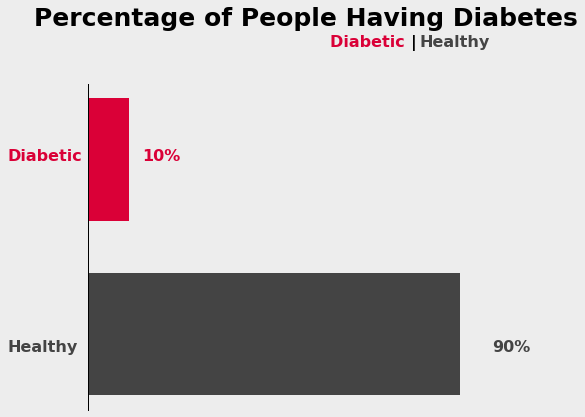

In [77]:
x = pd.DataFrame(df.groupby(['Outcome']).Outcome.count())

fig , ax = plt.subplots(figsize=(7,6))
ax.barh([1], x.Outcome[1], height=0.7, color= colors[3])
ax.barh([0], x.Outcome[0], height=0.7, color= colors[1])

fig.patch.set_facecolor(colors[2])
ax.set_facecolor(colors[2])

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.text(-150,-0.1, 'Healthy',{'weight':'bold','Size': '16','style':'normal', 'color':colors[1]})
plt.text(750,-0.1, '90%',{'weight':'bold' ,'size':'16','color':colors[1]})
plt.text(-150,1, 'Diabetic', {'weight':'bold','Size': '16','style':'normal', 'color':colors[3]})
plt.text(100,1, '10%',{ 'weight':'bold','size':'16','color':colors[3]})

plt.text(-100,1.77, 'Percentage of People Having Diabetes' ,{ 'Size': '25','weight':'bold', 'color':'black'})
plt.text(450,1.65, 'Diabetic ', {'weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':colors[3]})
plt.text(600,1.65, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
plt.text(615,1.65, 'Healthy', {'weight':'bold', 'Size': '16','style':'normal', 'weight':'bold','color':colors[1]})

plt.show()

3.2 Univariate Analysis

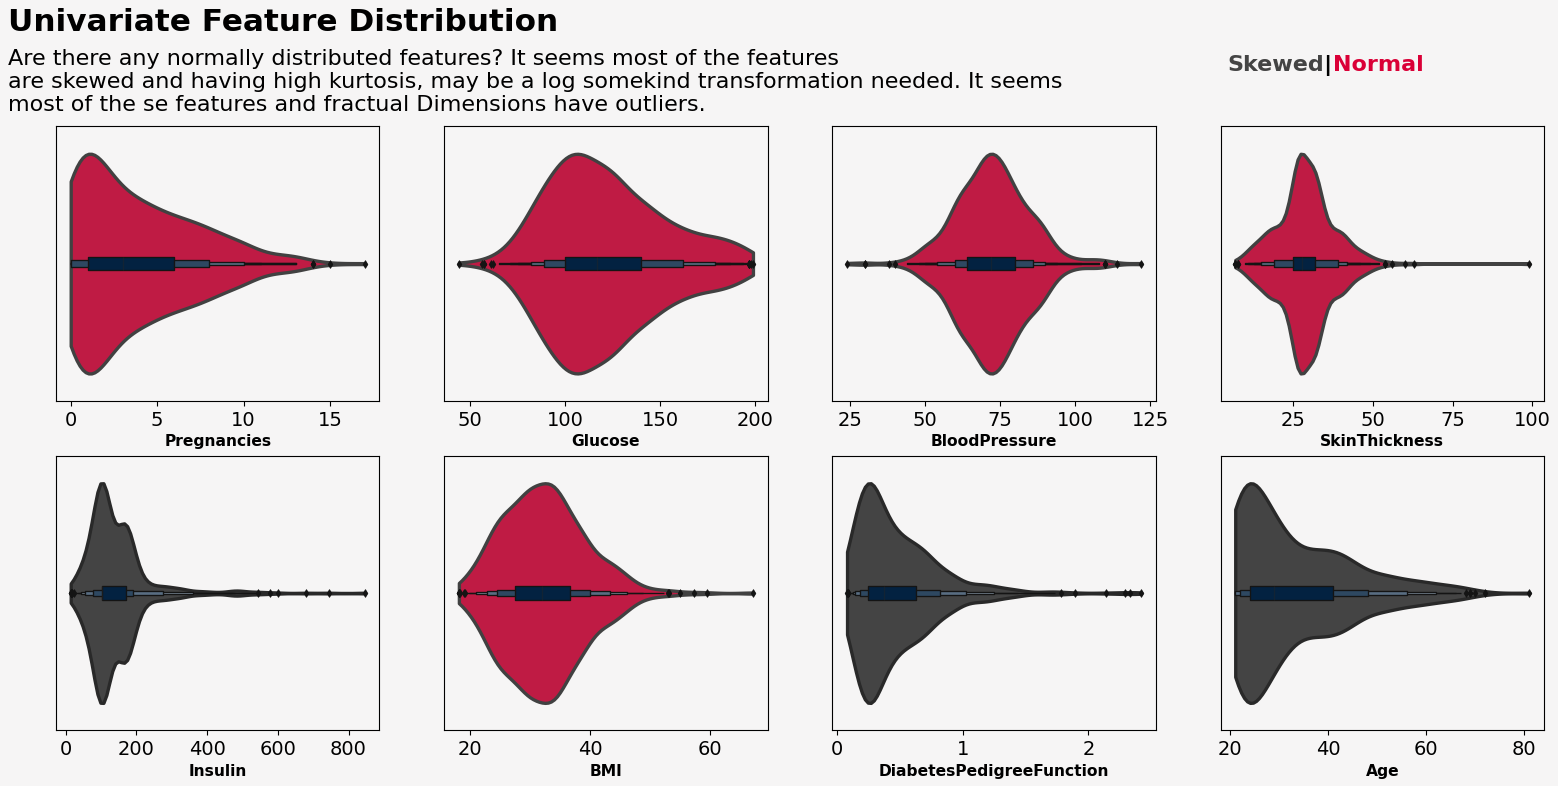

In [58]:
fig,ax = plt.subplots(nrows = 2, ncols = 4, figsize = (24,10),dpi=80)
fig.patch.set_facecolor('#f6f5f5')
axes = ax.ravel()

feat_df = df.iloc[:,:8]

for col,ax in zip(feat_df.columns,axes):
    
    # skewness
    if skew(feat_df[col])>1:
        color = colors[1]
    else:
        color = colors[3]
    
    sns.violinplot(feat_df[col], ax =ax,cut =0, 
                   color = color,inner = None,
                   alpha = 0.6,linewidth = 3,edgecolor = 'solidblack', saturation =0.75 )
    sns.boxenplot(x = df[col], ax = ax, saturation = 0.9,palette =[colors[4]],width=0.05)
    
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(True)
    ax.axes.set_xlabel(col,{'size':14, 'weight':'bold'}, alpha = 1)
    ax.set_facecolor('#f6f5f5')



## titles and text
fig.text(0.1,1,'Univariate Feature Distribution', {'size':28, 'weight':'bold'}, alpha = 1)
fig.text(0.1,0.90,'''Are there any normally distributed features? It seems most of the features
are skewed and having high kurtosis, may be a log somekind transformation needed. It seems
most of the se features and fractual Dimensions have outliers.  ''',{'size':20, 'weight':'normal'}, alpha = 1)    

fig.text(0.735,0.95, "Skewed",{'size':20, 'weight':'bold', 'color':colors[1]})
fig.text(0.785,0.95, '|',{'size':20, 'weight':'bold'})
fig.text(0.79,0.95, "Normal",{'size':20, 'weight':'bold','color':colors[3]})

fig.show()

Univariate Analysis of Categorical Data

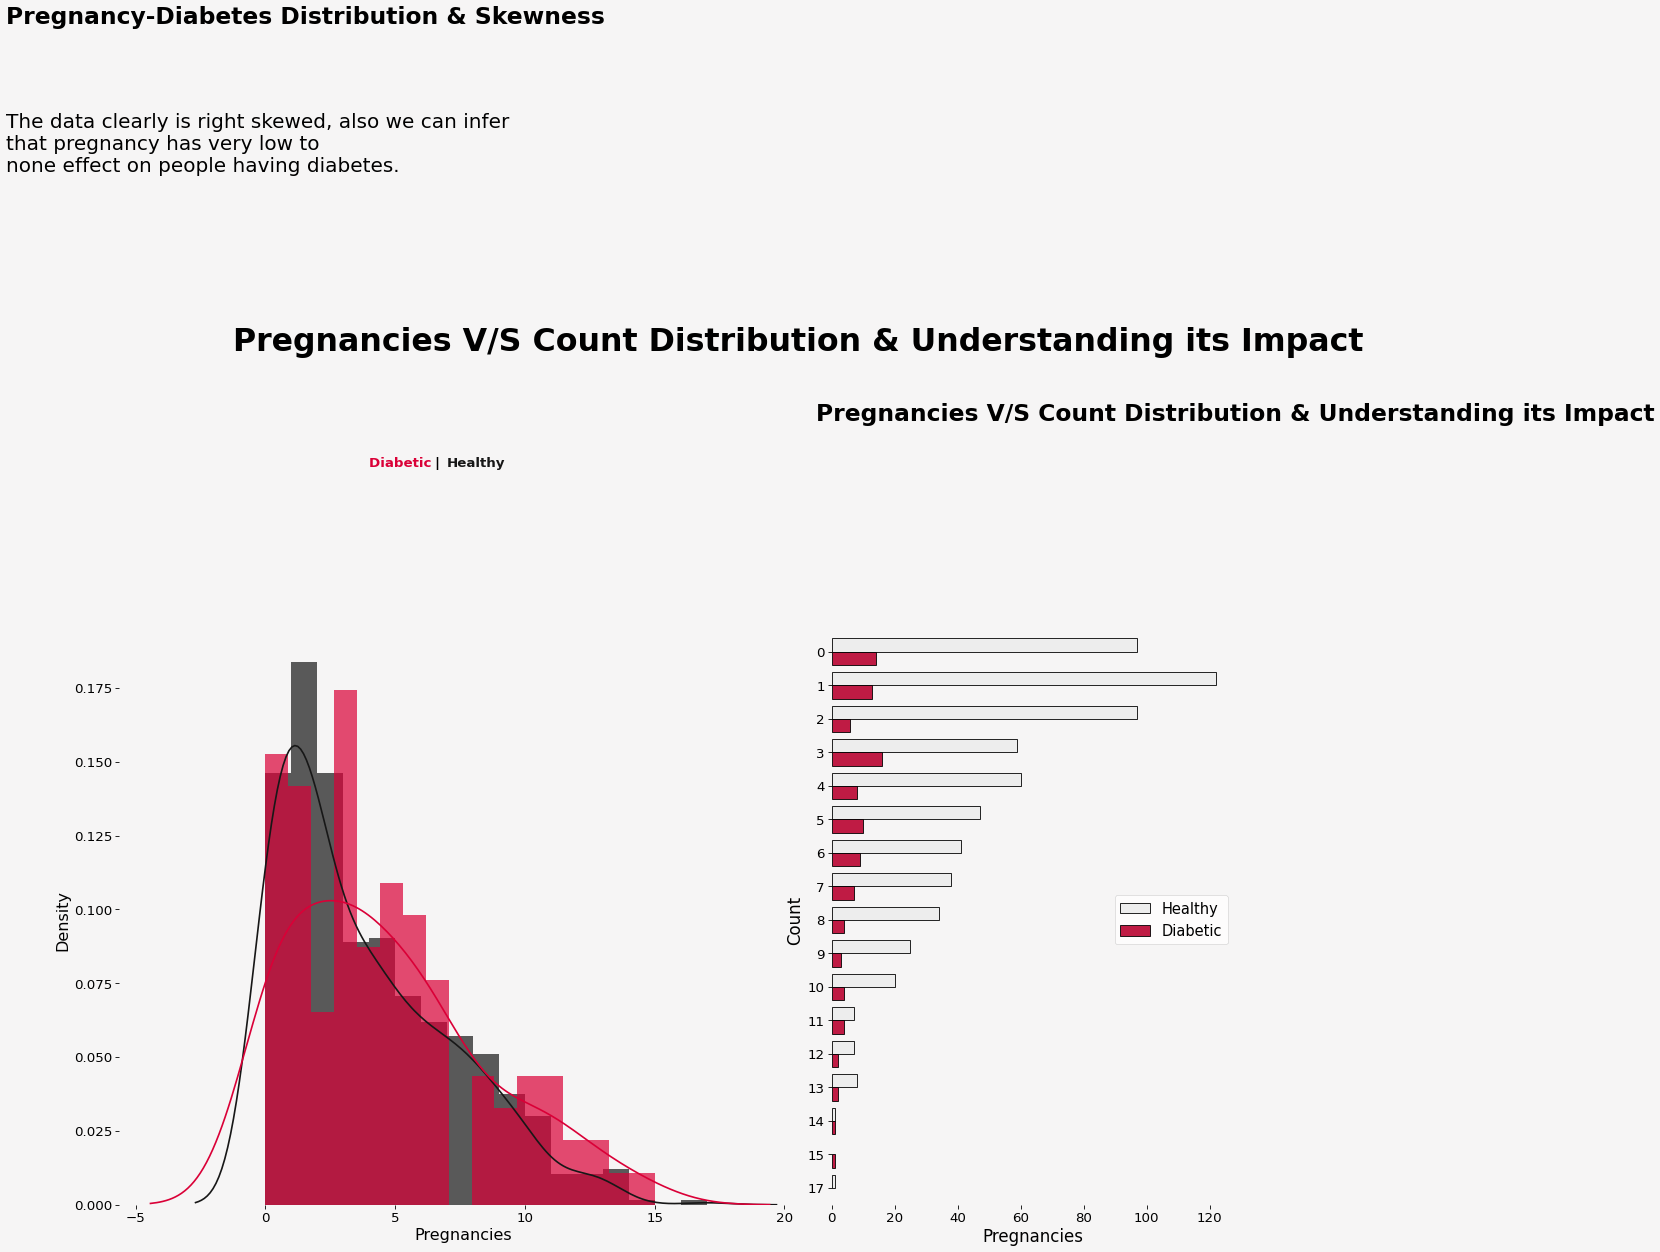

In [59]:
fig = plt.figure(figsize = (24,18),dpi = 60)

gs = fig.add_gridspec(10,24)
gs.update(wspace = 1, hspace = 0.05)


ax2 = fig.add_subplot(gs[2:9,:15]) #distribution plot
ax1 = fig.add_subplot(gs[2:9,15:]) #dumbbell plot

# axes list
axes = [ ax1,ax2]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.set_facecolor('#f6f5f5')
    
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

fig.patch.set_facecolor('#f6f5f5')
        
ax2.axes.get_xaxis().set_visible(True)
ax2.axes.get_yaxis().set_visible(True)
ax2.tick_params(labelsize=16)
ax1.tick_params(labelsize=16)
plt.ylabel('Count',fontdict={ 'color': 'black','size':20})
plt.xlabel('Pregnancies',fontdict={'color': 'black','size':20})
ax2.text(-10,0.4,'Pregnancy-Diabetes Distribution & Skewness', { 'color': 'black','weight':'bold','size':28})
ax2.text(-10,0.35,'The data clearly is right skewed, also we can infer\nthat pregnancy has very low to\nnone effect on people having diabetes. ',{ 'color': 'black','size':24})
ax2.text(4,0.25, 'Diabetic ', {'weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':colors[3]})
ax2.text(6.5,0.25, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
ax2.text(7,0.25, 'Healthy', {'weight':'bold', 'Size': '16','style':'normal', 'weight':'bold','color':colors[0]})

sns.distplot(df.loc[df['Outcome'] == 0, "Pregnancies"],bins=17, color=colors[0], label="Healthy", hist_kws={'alpha':.7}, kde_kws={'linewidth':2},ax=ax2)
sns.distplot(df.loc[df['Outcome'] == 1, "Pregnancies"],bins=17, color=colors[3], label="Diabetic", hist_kws={'alpha':.7}, kde_kws={'linewidth':2},ax=ax2)
plt.ylim(0, 1)



sns.countplot(y='Pregnancies',hue='Outcome',data=df,palette=sns.color_palette( palette = [colors[2],colors[3]]),linewidth=1,edgecolor=sns.color_palette(palette=['black']),ax=ax1)
plt.legend({'Healthy':0,'Diabetic':1})
ax1.text(-5,-6.9,'Pregnancies V/S Count Distribution & Understanding its Impact', { 'color': 'black','weight':'bold','size':28})
ax1.text(-190,-9,'Pregnancies V/S Count Distribution & Understanding its Impact', { 'color': 'black','weight':'bold','size':38})
ax1.axes.get_xaxis().set_visible(True)
ax1.axes.get_yaxis().set_visible(True)
sns.set_context("paper", font_scale=2)
plt.ylabel('Count',fontdict={ 'color': 'black','size':20})
plt.xlabel('Pregnancies',fontdict={ 'color': 'black','size':20})
fig.show()

3.2.4 Correlations

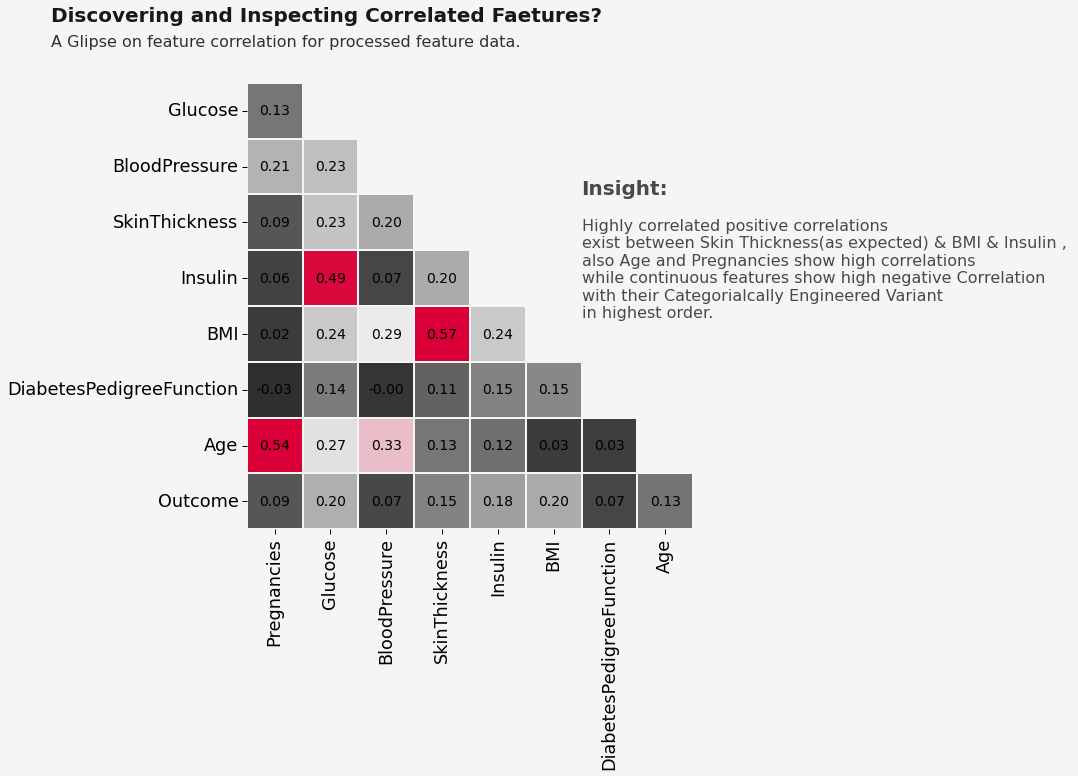

In [60]:
# preprocessing - label enconding and numerical value scaling
mm = MinMaxScaler()

df_copy = df.copy()

cols = df.columns[:-1]
## normalizing with standard scaler of numerical features
df[cols] = mm.fit_transform(df[cols])


# correlation map for all the features
df_corr = df.corr()
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

fig, ax = plt.subplots(figsize = (8,12))
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()


colorss = colors[:4]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colorss)

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",cmap = colormap,
           vmin=-0.15, vmax=0.5, cbar_kws={"shrink": .5, }, ax = ax, cbar = False,
           linewidth = 1,linecolor = '#f6f5f5', square = True,annot_kws = { 'size':14, 'color':'black'} )
# yticks
ax.tick_params(axis = 'y', rotation=0)
ax.text(-3.5,-1.1, 'Discovering and Inspecting Correlated Faetures?',{ 'size': 20, 'weight':'bold'}, alpha = 0.9)
ax.text(-3.5,-0.65, 'A Glipse on feature correlation for processed feature data.',{'size': 16, 'weight':'normal'}, alpha = 0.8)

ax.text(6,4.2, 'Highly correlated positive correlations \nexist between Skin Thickness(as expected) & BMI & Insulin , \nalso Age and Pregnancies show high correlations\nwhile continuous features show high negative Correlation\nwith their Categorialcally Engineered Variant\nin highest order.',{'size': 16, 'weight':'normal'},alpha = 0.7)
ax.text(6,2, 'Insight:',{'size': 20, 'weight':'bold'},alpha = 0.7)

fig.show()

4. Feature Selection

Solving the Problem of Skewness.

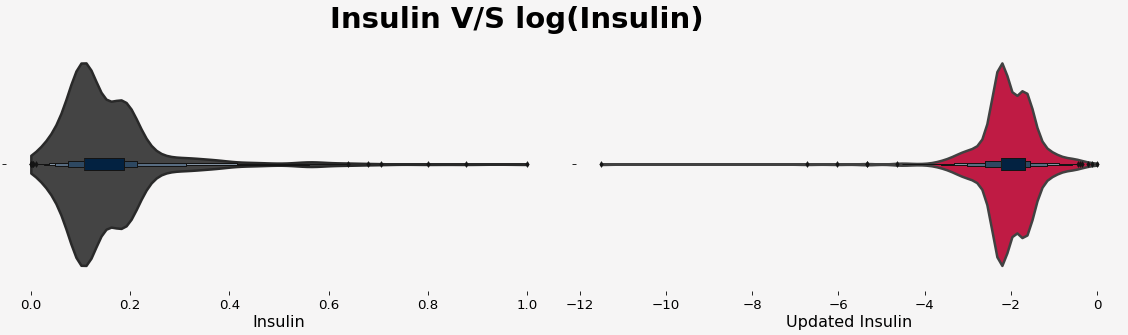

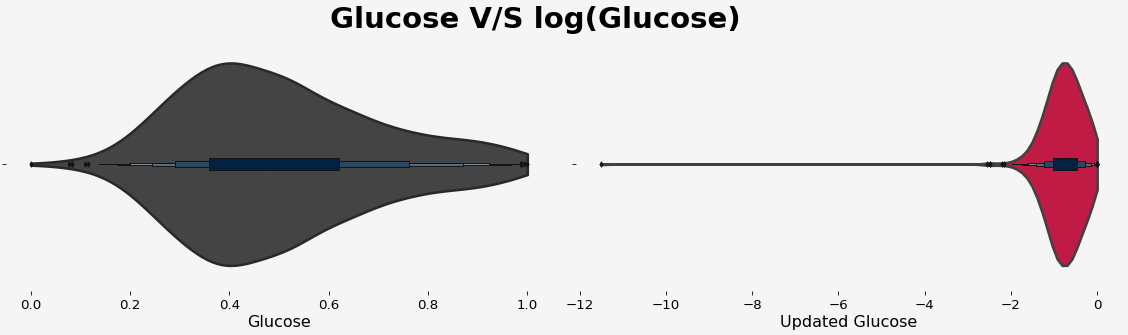

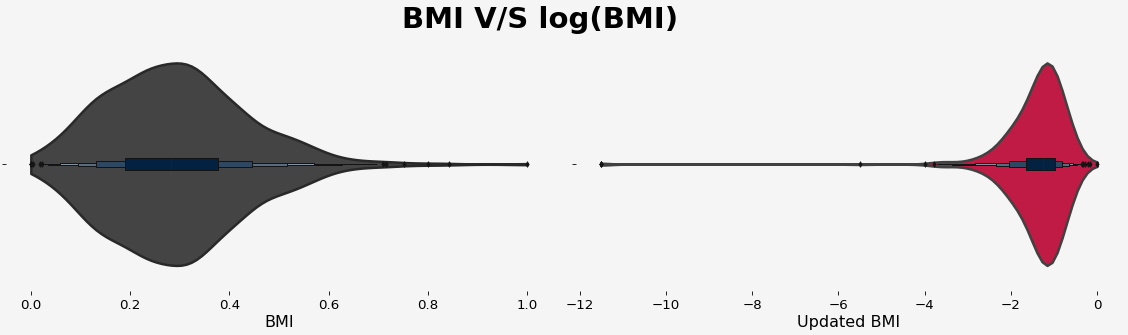

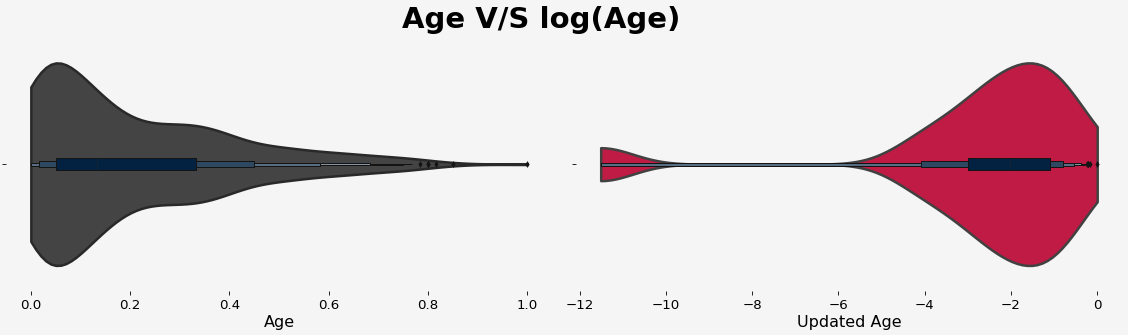

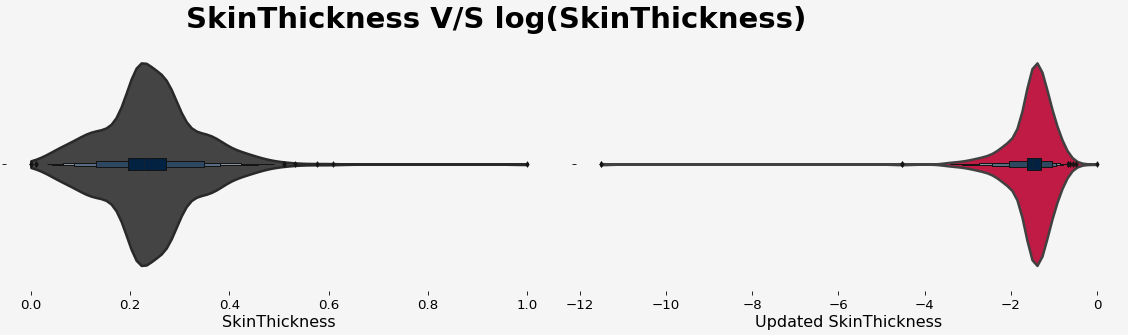

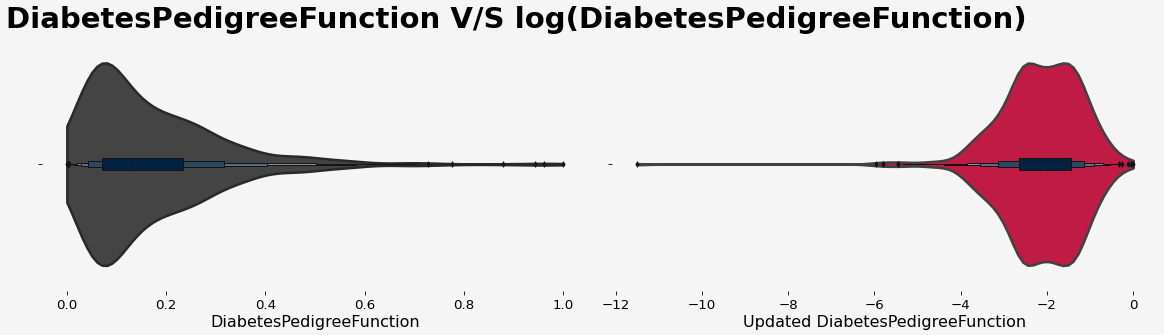

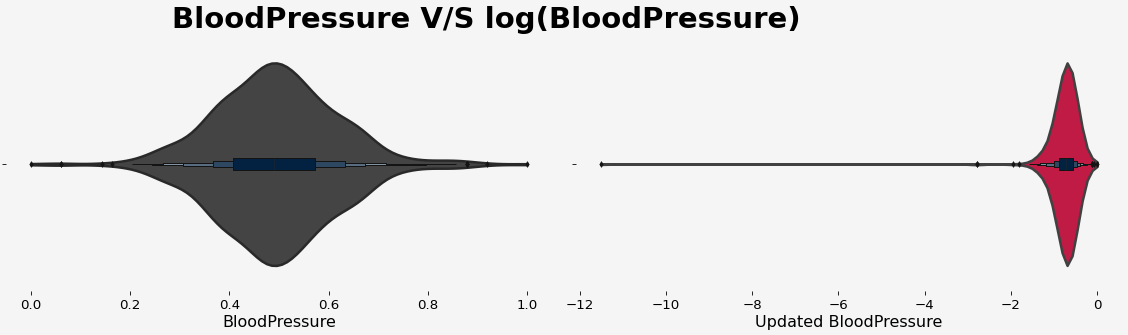

In [61]:
cols=df.columns[:-1]
df[cols] = df[cols].replace(0,1e-5)
X = df.drop(['Outcome'],axis=1)
feat = df.drop(['Outcome'],axis=1).columns
y = df['Outcome']
#---------------------------------------------------------------------------
#---------------------------------------------------------------------------
df['Insulin'] = X['Insulin'].apply(lambda x: np.log(x))
df['Glucose'] = X['Glucose'].apply(lambda x: np.log(x))
df['BMI'] = X['BMI'].apply(lambda x: np.log(x))
df['SkinThickness'] = X['SkinThickness'].apply(lambda x: np.log(x))
df['BloodPressure'] = X['BloodPressure'].apply(lambda x: np.log(x))
df['Age'] = X['Age'].apply(lambda x: np.log(x))
df['DiabetesPedigreeFunction'] = X['DiabetesPedigreeFunction'].apply(lambda x: np.log(x))

def plot_ready(x,pos):
    fig = plt.figure(figsize = (24,8),dpi = 60)

    gs = fig.add_gridspec(10,24)
    gs.update(wspace = 1, hspace = 0.05)


    ax2 = fig.add_subplot(gs[2:9,:12]) 
    ax1 = fig.add_subplot(gs[2:9,12:]) 
    # axes list
    axes = [ ax1,ax2]

    # setting of axes; visibility of axes and spines turn off
    for ax in axes:
        ax.set_facecolor('#f6f5f5')

        for loc in ['left', 'right', 'top', 'bottom']:
            ax.spines[loc].set_visible(False)

    fig.patch.set_facecolor('#f6f5f5')

    ax2.axes.get_xaxis().set_visible(True)
    ax2.axes.get_yaxis().set_visible(True)
    ax2.tick_params(labelsize=16)
    ax1.tick_params(labelsize=16)
    sns.violinplot(df[x], ax =ax1,cut =0, 
                   color = colors[3],inner = None,
                   alpha = 0.6,linewidth = 3,edgecolor = 'solidblack', saturation =0.75 )
    sns.boxenplot(x= df[x], ax = ax1, saturation = 0.9,palette =[colors[4]],width=0.05)
    sns.violinplot(X[x], ax =ax2,cut =0, 
                   color = colors[1],inner = None,
                   alpha = 0.6,linewidth = 3,edgecolor = 'solidblack', saturation =0.75 )
    sns.boxenplot(x = X[x], ax = ax2, saturation = 0.9,palette =[colors[4]],width=0.05)
    plt.xlabel('Updated '+x)
    fig.text(pos,0.75,f'{x} V/S log({x})',{ 'weight':'bold','color': 'black', 'size':35})
    return fig


features = ['Insulin','Glucose','BMI','Age','SkinThickness','DiabetesPedigreeFunction','BloodPressure']
pos = [0.35,0.35,0.4,0.4,0.25,0.1,0.24]
for x,z in zip(features,pos):
    fig = plot_ready(x,z)

4.2 Data Scaling

In [62]:
X = df.drop(['Outcome'],axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, shuffle = True, random_state = 42)
def make_classification(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, shuffle = True, random_state = 42)
    accuracy,precision,recall,f1,auc,conf_mat= [],[],[],[],[],[]

    random_state = 2

    ##classifiers 
    classifiers = []
    classifiers.append(SVC(random_state=random_state, probability = True))
    classifiers.append(DecisionTreeClassifier(random_state=random_state))
    classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state)))
    classifiers.append(RandomForestClassifier(random_state=random_state))
    classifiers.append(GradientBoostingClassifier(random_state=random_state))
    classifiers.append(KNeighborsClassifier())
    classifiers.append(LogisticRegression(random_state = random_state))
    classifiers.append(XGBClassifier(random_state = random_state))
    classifiers.append(LGBMClassifier(random_state = random_state))
    classifiers.append(LinearDiscriminantAnalysis())
    classifiers.append(QuadraticDiscriminantAnalysis())
    classifiers.append(ExtraTreesClassifier())

    for classifier in classifiers:

        #classifier and fitting
        clf = classifier
        clf.fit(X_train,y_train)

        #predictions
        y_preds = clf.predict(X_test)
        y_probs = clf.predict_proba(X_test)

        # metrics
        accuracy.append((round(accuracy_score(y_test,y_preds),2))*100)
        precision.append((round(precision_score(y_test,y_preds),2))*100)
        recall.append((round(recall_score(y_test,y_preds),2))*100)
        f1.append((round(f1_score(y_test,y_preds),2))*100)
        auc.append((round (roc_auc_score(y_test,y_probs[:,1]), 2))*100)
        conf_mat.append(confusion_matrix(y_test,y_preds))

    results_df = pd.DataFrame({"Accuracy Score":accuracy,"Precision Score":precision,
                        "Recall Score":recall, "f1 Score":f1,"AUC Score":auc,
                        "Confusion Matrix":conf_mat,
                        "Algos":["SVC","DecisionTree","AdaBoost",
                                     "RandomForest","GradientBoosting",
                                     "KNeighboors","LogisticRegression",
                                     "XGBoost", "LightGBM","LDA","QDA","ExtraTrees"]})

    results = (results_df.sort_values(by = ['AUC Score','f1 Score'], ascending = False)
                  .reset_index(drop =  True))
    return classifiers,results
classifiers,results = make_classification(X,y)

In [63]:
results

,Accuracy Score,Precision Score,Recall Score,f1 Score,AUC Score,Confusion Matrix,Algos
0,88.0,43.0,18.0,25.0,83.0,"[[133, 4], [14, 3]]",RandomForest
1,84.0,28.0,29.0,29.0,82.0,"[[124, 13], [12, 5]]",LightGBM
2,89.0,0.0,0.0,0.0,82.0,"[[137, 0], [17, 0]]",LDA
3,87.0,38.0,29.0,33.0,79.0,"[[129, 8], [12, 5]]",XGBoost
4,84.0,17.0,12.0,14.0,79.0,"[[127, 10], [15, 2]]",GradientBoosting
5,88.0,0.0,0.0,0.0,79.0,"[[135, 2], [17, 0]]",LogisticRegression
6,82.0,18.0,18.0,18.0,76.0,"[[123, 14], [14, 3]]",KNeighboors
7,87.0,20.0,6.0,9.0,75.0,"[[133, 4], [16, 1]]",ExtraTrees
8,89.0,0.0,0.0,0.0,75.0,"[[137, 0], [17, 0]]",SVC
9,60.0,18.0,76.0,30.0,68.0,"[[79, 58], [4, 13]]",QDA


4.3 Feature Selection

4.3.1 Feature Importance by weights:

In [64]:
X_train = X_train.copy()
clf = XGBClassifier()
clf.fit(X_train,y_train)
key,value = clf.get_booster().get_score(importance_type='weight').keys(),clf.get_booster().get_score(importance_type='weight').values()
imp = pd.DataFrame(index=key)
imp['Feature Importance'] = value
imp.sort_values(by='Feature Importance',ascending=False)

,Feature Importance
Insulin,123
DiabetesPedigreeFunction,98
BMI,85
Glucose,72
BloodPressure,68
Age,58
SkinThickness,56
Pregnancies,30


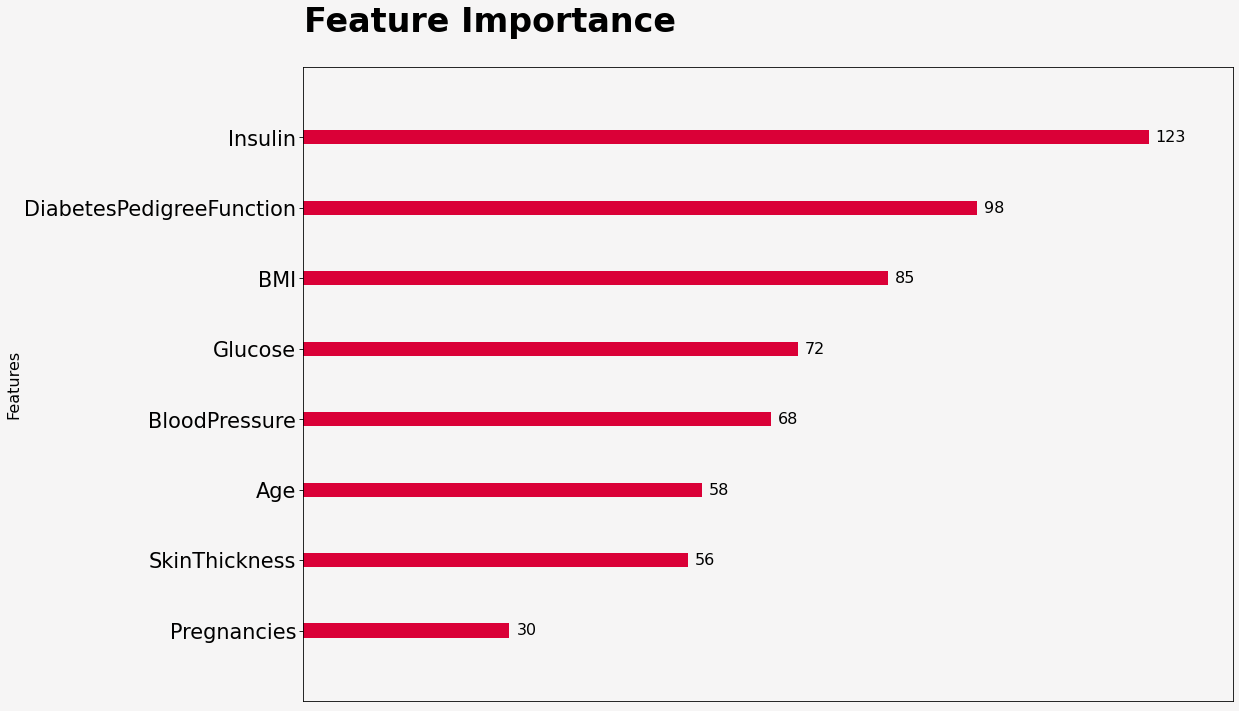

In [65]:
from xgboost import plot_importance

fig = plt.figure(figsize = (20,14),dpi = 60)
ax = fig.add_subplot()
ax.text(0.08,8.5,'Feature Importance',{ 'size':40,'weight':'bold','color':'black'})
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(True)
ax.tick_params(colors = 'black',labelsize=25,grid_color='#f6f5f5')
plot_importance(clf,ax=ax,grid=False,color=[colors[3]],title=None)
fig.show()

Testing Model For Different Thresholds based on Feature Importances

In [66]:
from sklearn.feature_selection import SelectFromModel

X_train_rand = X_train.copy()

X_test_rand = X_test.copy()


clf = RandomForestClassifier()
clf.fit(X_train_rand,y_train)
#clf.get_booster().get_score(importance_type='weight')
accuracy_score(y_test,clf.predict(X_test_rand))
thresholds = sorted(clf.feature_importances_)
eval_set = [(X_train_rand, y_train), (X_test_rand, y_test)]
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(clf, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_rand)
    # train model
    selection_model = RandomForestClassifier(random_state=2)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test_rand)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.083, n=8, Accuracy: 88.31%
Thresh=0.113, n=7, Accuracy: 87.66%
Thresh=0.121, n=6, Accuracy: 87.66%
Thresh=0.121, n=5, Accuracy: 89.61%
Thresh=0.122, n=4, Accuracy: 89.61%
Thresh=0.126, n=3, Accuracy: 90.26%
Thresh=0.139, n=2, Accuracy: 85.71%
Thresh=0.175, n=1, Accuracy: 85.71%


4.3.2 Feature Importance by adding Random Colum

In [67]:
np.random.RandomState(42)
X_train_rand = X_train.copy()
X_train_rand['Random'] = np.random.normal(size=len(X_train_rand))
clf = XGBClassifier(random=42)
clf.fit(X_train_rand,y_train)

key,value = clf.get_booster().get_score(importance_type='weight').keys(),clf.get_booster().get_score(importance_type='weight').values()
imp = pd.DataFrame(index=key)
imp['Feature Importance'] = value
imp = imp.sort_values(by='Feature Importance',ascending=False)

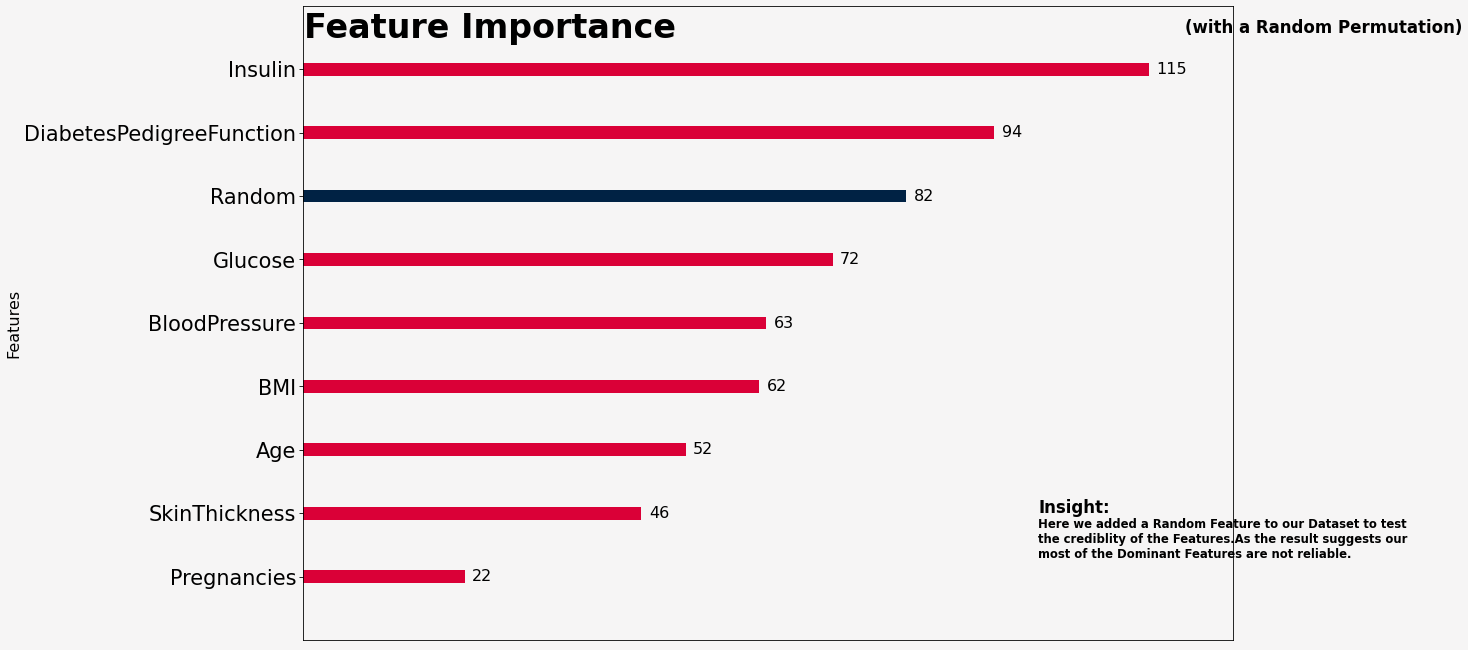

In [68]:
fig = plt.figure(figsize = (20,14),dpi = 60)
ax = fig.add_subplot()

ax.text(0.08,8.5,'Feature Importance',{ 'size':40,'weight':'bold','color':'black'})
ax.text(120,8.57,'(with a Random Permutation)',{ 'size':20,'weight':'bold','color':'black'})
ax.text(100,1,'Insight:',{'size':20,'weight':'bold','color':'black'})
ax.text(100,0.3,'Here we added a Random Feature to our Dataset to test\nthe crediblity of the Features.As the result suggests our \nmost of the Dominant Features are not reliable.',{ 'size':14,'weight':'bold','color':'black'})
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(True)
ax.tick_params(colors = 'black',labelsize=25,grid_color='#f6f5f5')
plot_importance(clf,ax=ax,grid=False,color=[colors[4] if x=='Random' else colors[3] for x in imp.index][::-1],title=None)
fig.show()

In [69]:
from sklearn.feature_selection import SelectFromModel

X_test_rand = X_test.copy()
X_test_rand['Random'] = np.random.random(size=len(X_test_rand))

model_select = RandomForestClassifier()
model_select.fit(X_train_rand,y_train)
#clf.get_booster().get_score(importance_type='weight')
accuracy_score(y_test,model_select.predict(X_test_rand))
thresholds = sorted(model_select.feature_importances_)
max_acc,thresh_max =0,0 
eval_set = [(X_train_rand, y_train), (X_test_rand, y_test)]
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model_select, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_rand)
    
    selection_model = RandomForestClassifier(random_state=2)
    selection_model.fit(select_X_train, y_train)

    select_X_test = selection.transform(X_test_rand)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    if accuracy>max_acc:
        max_acc,thresh_max=accuracy,thresh
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.068, n=9, Accuracy: 88.31%
Thresh=0.092, n=8, Accuracy: 88.31%
Thresh=0.103, n=7, Accuracy: 88.31%
Thresh=0.106, n=6, Accuracy: 88.31%
Thresh=0.111, n=5, Accuracy: 90.26%
Thresh=0.113, n=4, Accuracy: 88.31%
Thresh=0.115, n=3, Accuracy: 87.01%
Thresh=0.117, n=2, Accuracy: 85.71%
Thresh=0.175, n=1, Accuracy: 85.71%


4.3.3 Feature Importance by Permutation

In [70]:
from sklearn.inspection import permutation_importance

model = XGBClassifier()
model.fit(X_train,y_train)

res = permutation_importance(model, X, y, scoring='accuracy')
imp = res.importances_mean

for i,v in enumerate(imp):
    sp = " "*(25-len(X_train.columns[i]))
    print(f'{X_train.columns[i]} {sp} Score: {v}')

Pregnancies                Score: 0.006770833333333326
Glucose                    Score: 0.026041666666666675
BloodPressure              Score: 0.020572916666666698
SkinThickness              Score: 0.015625
Insulin                    Score: 0.05208333333333333
BMI                        Score: 0.033333333333333326
DiabetesPedigreeFunction   Score: 0.027604166666666673
Age                        Score: 0.02395833333333335


In [71]:
# feature transform
model_select = GradientBoostingClassifier()
model_select.fit(X_train,y_train)
#clf.get_booster().get_score(importance_type='weight')
accuracy_score(y_test,model_select.predict(X_test))
thresholds = sorted(model_select.feature_importances_)
max_acc,thresh_max =0,0 
eval_set = [(X_train, y_train), (X_test, y_test)]
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model_select, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    selection_model = RandomForestClassifier(random_state=2)
    selection_model.fit(select_X_train, y_train)

    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    if accuracy>max_acc:
        max_acc,thresh_max=accuracy,thresh


selection = SelectFromModel(model_select, threshold=thresh_max, prefit=True)
X_selected = selection.transform(X)
classfiers,res_df=make_classification(X_selected,y)

5. Modelling & Visualization

In [72]:
def multi_visualize(data, vmin = -0.5, vmax = 1):
    fig = plt.figure(figsize =(24,34))
    gs = fig.add_gridspec(8,4)
    gs.update(wspace = 0.2, hspace = 0.2)
    
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[0,2])
    
    ax4 = fig.add_subplot(gs[1,0])
    ax5 = fig.add_subplot(gs[1,1])
    ax6 = fig.add_subplot(gs[1,2])
    
    ax7 = fig.add_subplot(gs[2,0])
    ax8 = fig.add_subplot(gs[2,1])
    ax9 = fig.add_subplot(gs[2,2])
    
    ax10 = fig.add_subplot(gs[3,0])
    ax11 = fig.add_subplot(gs[3,1])
    ax12 = fig.add_subplot(gs[3,2])
    
    
    axes1 = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9,ax10,ax11,ax12]
    
    ax_list = axes1
    
    fig.patch.set_facecolor('#f6f5f5')
    
    # setting of axes; visibility of axes and spines turn off
    for ax in ax_list:
        ax.axes.get_yaxis().set_visible(False)
        ax.axes.get_xaxis().set_visible(False)
        ax.set_facecolor('#f6f5f5')

    colorss = ['#512b58','#fe346e']
    colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colorss)
        
    res_df = data[0]
        
    acc = res_df['Accuracy Score']   
    alg = res_df['Algos']
    cf = res_df['Confusion Matrix']
    auc = res_df['AUC Score']
    f1 = res_df['f1 Score']
    forig = data[0]['f1 Score']
        
    n = 0
    for ax in ax_list:
        cf_mat = cf[n]

        #### annotations
        labels = ['True Neg','False Pos','False Neg','True Pos']
        counts = ["{0:0.0f}".format(value) for value in cf_mat.flatten()]
        percentages = ["{0:.2%}".format(value) for value in cf_mat.flatten()/np.sum(cf_mat)]

        #### final annotations
        label = (np.array([f'{v1}\n{v2}\n{v3}' for v1,v2,v3 in zip(labels,counts,percentages)])).reshape(2,2)

        #### heatmap
        sns.heatmap(data = cf_mat, vmin = vmin, vmax =vmax, cmap = ['grey'],linewidth=2,linecolor = '#f6f5f5',
           ax = ax, annot = label, fmt ='', cbar = False, annot_kws = {'size':16, 'color':'white','weight':'bold'}, alpha =0.8)

        #### subtitle
        ax.text(0,0.1,'{}'.format(alg[n]),{'size':16, 'color':'black', 'weight':'bold'})

        #### Auc and F1 score plotting

        if (auc[n] > 90):
            ax.scatter( 1 , 1 , s = 3500, c = '#fe346e')
            ax.text(0.8,1.1, ' Acc: {}\nAUC: {}'.format(int(round(acc[n],1)), int(round(auc[n],1))),{'size':12, 'color':'black', 'weight':'bold'})
        else:
            ax.scatter( 1 , 1 , s = 3500, c = colors[4])
            ax.text(0.8,1.1, ' Acc: {}\nAUC: {}'.format(int(round(acc[n],1)), int(round(auc[n],1))),{'size':12, 'color':'white', 'weight':'bold'})

        n +=1
    ax1.text(0,-0.55,'Visualization of Results with - Original Data',{'size':24, 'color':'black', 'weight':'bold'},)


fig.show()

In [74]:
results

,Accuracy Score,Precision Score,Recall Score,f1 Score,AUC Score,Confusion Matrix,Algos
0,88.0,43.0,18.0,25.0,83.0,"[[133, 4], [14, 3]]",RandomForest
1,84.0,28.0,29.0,29.0,82.0,"[[124, 13], [12, 5]]",LightGBM
2,89.0,0.0,0.0,0.0,82.0,"[[137, 0], [17, 0]]",LDA
3,87.0,38.0,29.0,33.0,79.0,"[[129, 8], [12, 5]]",XGBoost
4,84.0,17.0,12.0,14.0,79.0,"[[127, 10], [15, 2]]",GradientBoosting
5,88.0,0.0,0.0,0.0,79.0,"[[135, 2], [17, 0]]",LogisticRegression
6,82.0,18.0,18.0,18.0,76.0,"[[123, 14], [14, 3]]",KNeighboors
7,87.0,20.0,6.0,9.0,75.0,"[[133, 4], [16, 1]]",ExtraTrees
8,89.0,0.0,0.0,0.0,75.0,"[[137, 0], [17, 0]]",SVC
9,60.0,18.0,76.0,30.0,68.0,"[[79, 58], [4, 13]]",QDA


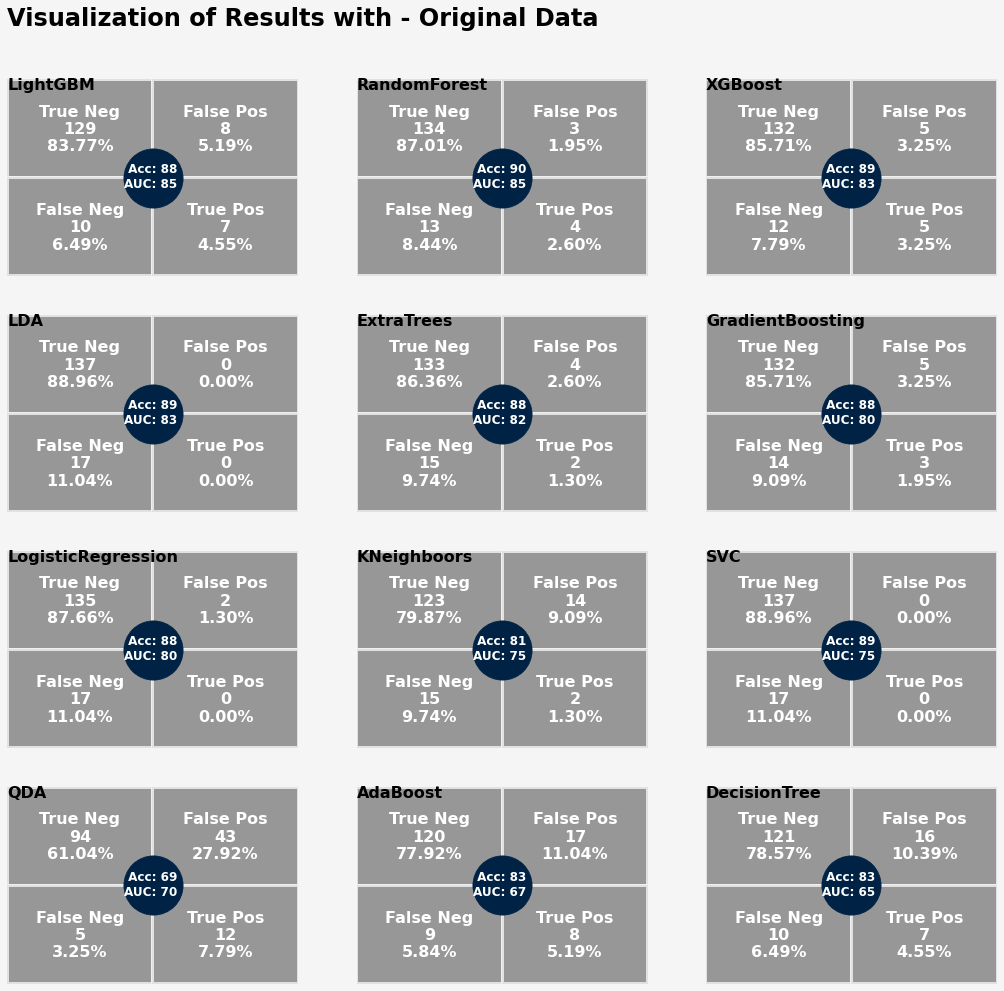

In [73]:
multi_visualize(data = [res_df], vmin=30,vmax = 100)